In [1]:
from google.cloud import vision
import json
from PIL import Image
import requests
from bs4 import BeautifulSoup

from transformers import pipeline

In [2]:
def get_data(i):
    visual_news_data = json.load(open("../../datasets/visualnews/origin/data.json"))
    visual_news_data_mapping = {ann["id"]: ann for ann in visual_news_data}

    data = json.load(open("../../news_clippings/news_clippings/data/merged_balanced/val.json"))
    annotations = data["annotations"]
    ann_true = annotations[i]

    caption = visual_news_data_mapping[ann_true["id"]]["caption"]
    image_path = visual_news_data_mapping[ann_true["image_id"]]["image_path"]
    image_path = "../../datasets/visualnews/origin/"+image_path[2:]
    image = Image.open(image_path)
    print("DATA SAMPLE")
    display(image)
    print("Caption: ", caption)
    print("Misinformation (Ground Truth): {}".format(ann_true["falsified"]))
    return image, caption, image_path

DATA SAMPLE


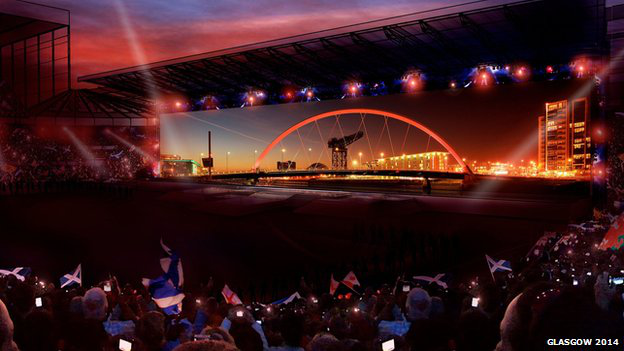

Caption:  The Brandenburg Gate stands illuminated during celebrations on the 25th anniversary of the fall of the Berlin Wall
Misinformation (Ground Truth): True


In [3]:
image, caption, image_path = get_data(5)

In [4]:

matching_urls = []
client = vision.ImageAnnotatorClient()
with open(image_path, "rb") as image_file:
    content = image_file.read()

image = vision.Image(content=content)

response = client.web_detection(image=image)
annotations = response.web_detection


if annotations.pages_with_matching_images:
    print(
        "\n{} Pages with matching images found:".format(
            len(annotations.pages_with_matching_images)
        )
    )

    for page in annotations.pages_with_matching_images:
        print(f"\n\tPage url   : {page.url}")
        matching_urls.append(page.url)

        if page.full_matching_images:
            print(
                "\t{} Full Matches found: ".format(len(page.full_matching_images))
            )

            for image in page.full_matching_images:
                print(f"\t\tImage url  : {image.url}")

        if page.partial_matching_images:
            print(
                "\t{} Partial Matches found: ".format(
                    len(page.partial_matching_images)
                )
            )

            for image in page.partial_matching_images:
                print(f"\t\tImage url  : {image.url}")

if response.error.message:
    raise Exception(
        "{}\nFor more info on error messages, check: "
        "https://cloud.google.com/apis/design/errors".format(response.error.message)
    )



1 Pages with matching images found:

	Page url   : https://www.bbc.com/news/uk-scotland-26765231
	1 Full Matches found: 
		Image url  : http://news.bbcimg.co.uk/media/images/73842000/jpg/_73842890_tv021598785(1).jpg


In [5]:
matching_urls

['https://www.bbc.com/news/uk-scotland-26765231',
 'http://stadiumdb.com/news/2014/07/glasgow_commonwealth_games_kick_off',
 'http://stadiony.net/aktualnosci/2014/07/glasgow_startuja_igrzyska_wspolnoty_2014']

## get text from webpages

In [6]:
request = requests.get(matching_urls[0])
soup = BeautifulSoup(request.text, "html.parser")

In [33]:
soup.title.string

'Glasgow 2014: What will the legacy of the Commonwealth Games legacy be? - BBC News'

## summarize retrieved text

In [7]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

In [29]:
text = soup.text

In [30]:
text

'Glasgow 2014: What will the legacy of the Commonwealth Games legacy be? - BBC NewsBBC HomepageSkip to contentAccessibility HelpYour accountNotificationsHomeNewsSportWeatheriPlayerSoundsBitesizeMore menuMore menuSearch BBCHomeNewsSportWeatheriPlayerSoundsBitesizeCBBCCBeebiesFoodClose menuBBC NewsMenuHomeElection 2024InDepthIsrael-Gaza warCost of LivingWar in UkraineClimateUKWorldBusinessMorePoliticsCultureTechScienceHealthFamily & EducationIn PicturesNewsbeatBBC VerifyDisabilityScotlandScotland PoliticsScotland BusinessEdinburgh, Fife & EastGlasgow & WestHighlands & IslandsNE, Orkney & ShetlandSouthTayside & CentralAlbaGlasgow 2014: What will the legacy of the Commonwealth Games legacy be?Published27 March 2014Shareclose panelShare pageCopy linkAbout sharingImage source, PAImage caption, Glasgow\'s Commonwealth Games will open with a blaze of colour and spectacle, but what will be their lasting legacy to the city?By Lisa SummersCommonwealth Games reporter, BBC ScotlandIt was in 2002 th

In [ ]:
summary = summarizer(text, max_length=512, min_length=50)
print(summary[0]['summary_text'])